# Reconstructing a food web using FishBase data

We will focus on teleost fish, class _Actinopterygii_, and elasmobranchs, class _Elasmobranchii_. We will use the FishBase database to reconstruct a food web of these two classes. We will use the `rfishbase` R package to access the FishBase database.

In [1]:
%load_ext rpy2.ipython

## Extract fish species for the Galapagos POC

From: 

1. https://github.com/leholman/GalapeDNA
2. https://www.biorxiv.org/content/10.1101/2024.03.06.583537v1.full

In [2]:
import pandas as pd

df = pd.read_csv('leholman/taxonomy.csv')
fish = df[df["B.class"].isin(["Actinopteri", "Chondrichthyes"])]

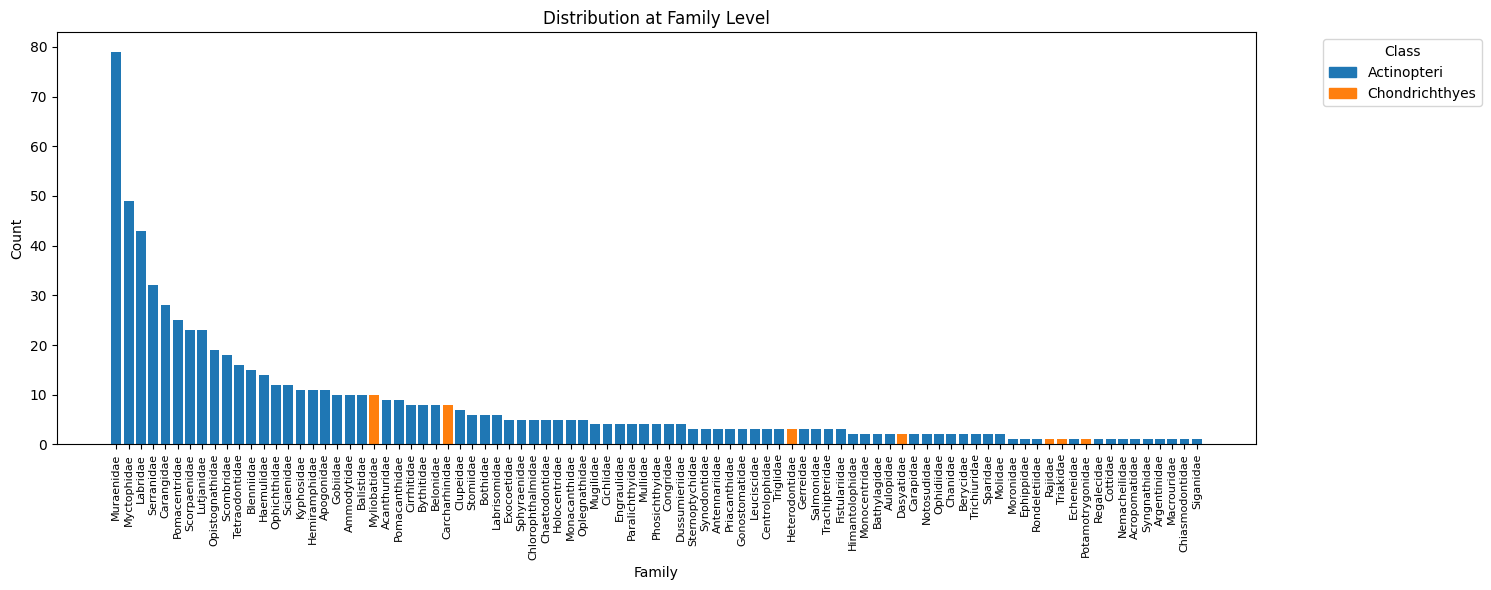

In [3]:
from src.helpers import plot_family_distribution

plot_family_distribution(fish)

In [4]:
fish_result = (fish[['ID', 'B.class', 'B.family', 'B.species']]
               .dropna(subset=['B.class', 'B.family', 'B.species'], how='all')
               .dropna(subset=['B.species'], how='all')
               .groupby(['B.class', 'B.family', 'B.species'])['ID'].agg(','.join).reset_index())

fish_result.to_csv('outputs/galapagos_fish_taxonomy.csv', index=False)

## Reconstruct food web with FishBase data

In [4]:
%%R

source("src/helpers.R")

input_file <- "outputs/galapagos_fish_taxonomy.csv"
output_file <- "outputs/galapagos_trophic_info.csv"

main(input_file, output_file)

Rows: 168 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): B.class, B.family, B.species, ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(SpecCode)`
Joining with `by = join_by(SpecCode)`
[1] "Output saved to outputs/galapagos_trophic_info.csv"


## Adding station ID to trophic info table

In [ ]:
from src.helpers import add_station_to_trophic_info

station_file = "leholman/Cleaned_Master_wTAX.csv"
trophic_file = "outputs/galapagos_trophic_info.csv"
output_file = "outputs/galapagos_trophic_info_with_station.csv"
station_ids = [
    "BAR", "CDOU", "CHAM", "CMAR", "CORA", "CUEV", "DAPH", "EGAS", "ELI", "GARD",
    "PCAL", "PESP", "PIN", "PLAZ", "PMAN", "PMOR", "PROJ", "PVIC", "RED", "SOMB",
    "STAFE", "SUAR", "TOR"
]

add_station_to_trophic_info(station_file, trophic_file, output_file, station_ids)

## Build food web

In [10]:
import pandas as pd
from src.helpers import create_trophic_web, save_graph, add_asv_ids_to_graph_data


df = pd.read_csv('outputs/galapagos_trophic_info_with_station.csv')
df = df.dropna(subset=['Troph'])


G = create_trophic_web(df, station_id="BAR")
save_graph(G, 'outputs/trophic_web_BAR.tsv')
add_asv_ids_to_graph_data(
    'outputs/trophic_web_BAR.tsv',
    'outputs/galapagos_fish_taxonomy.csv',
    'outputs/trophic_web_BAR.tsv'
    )

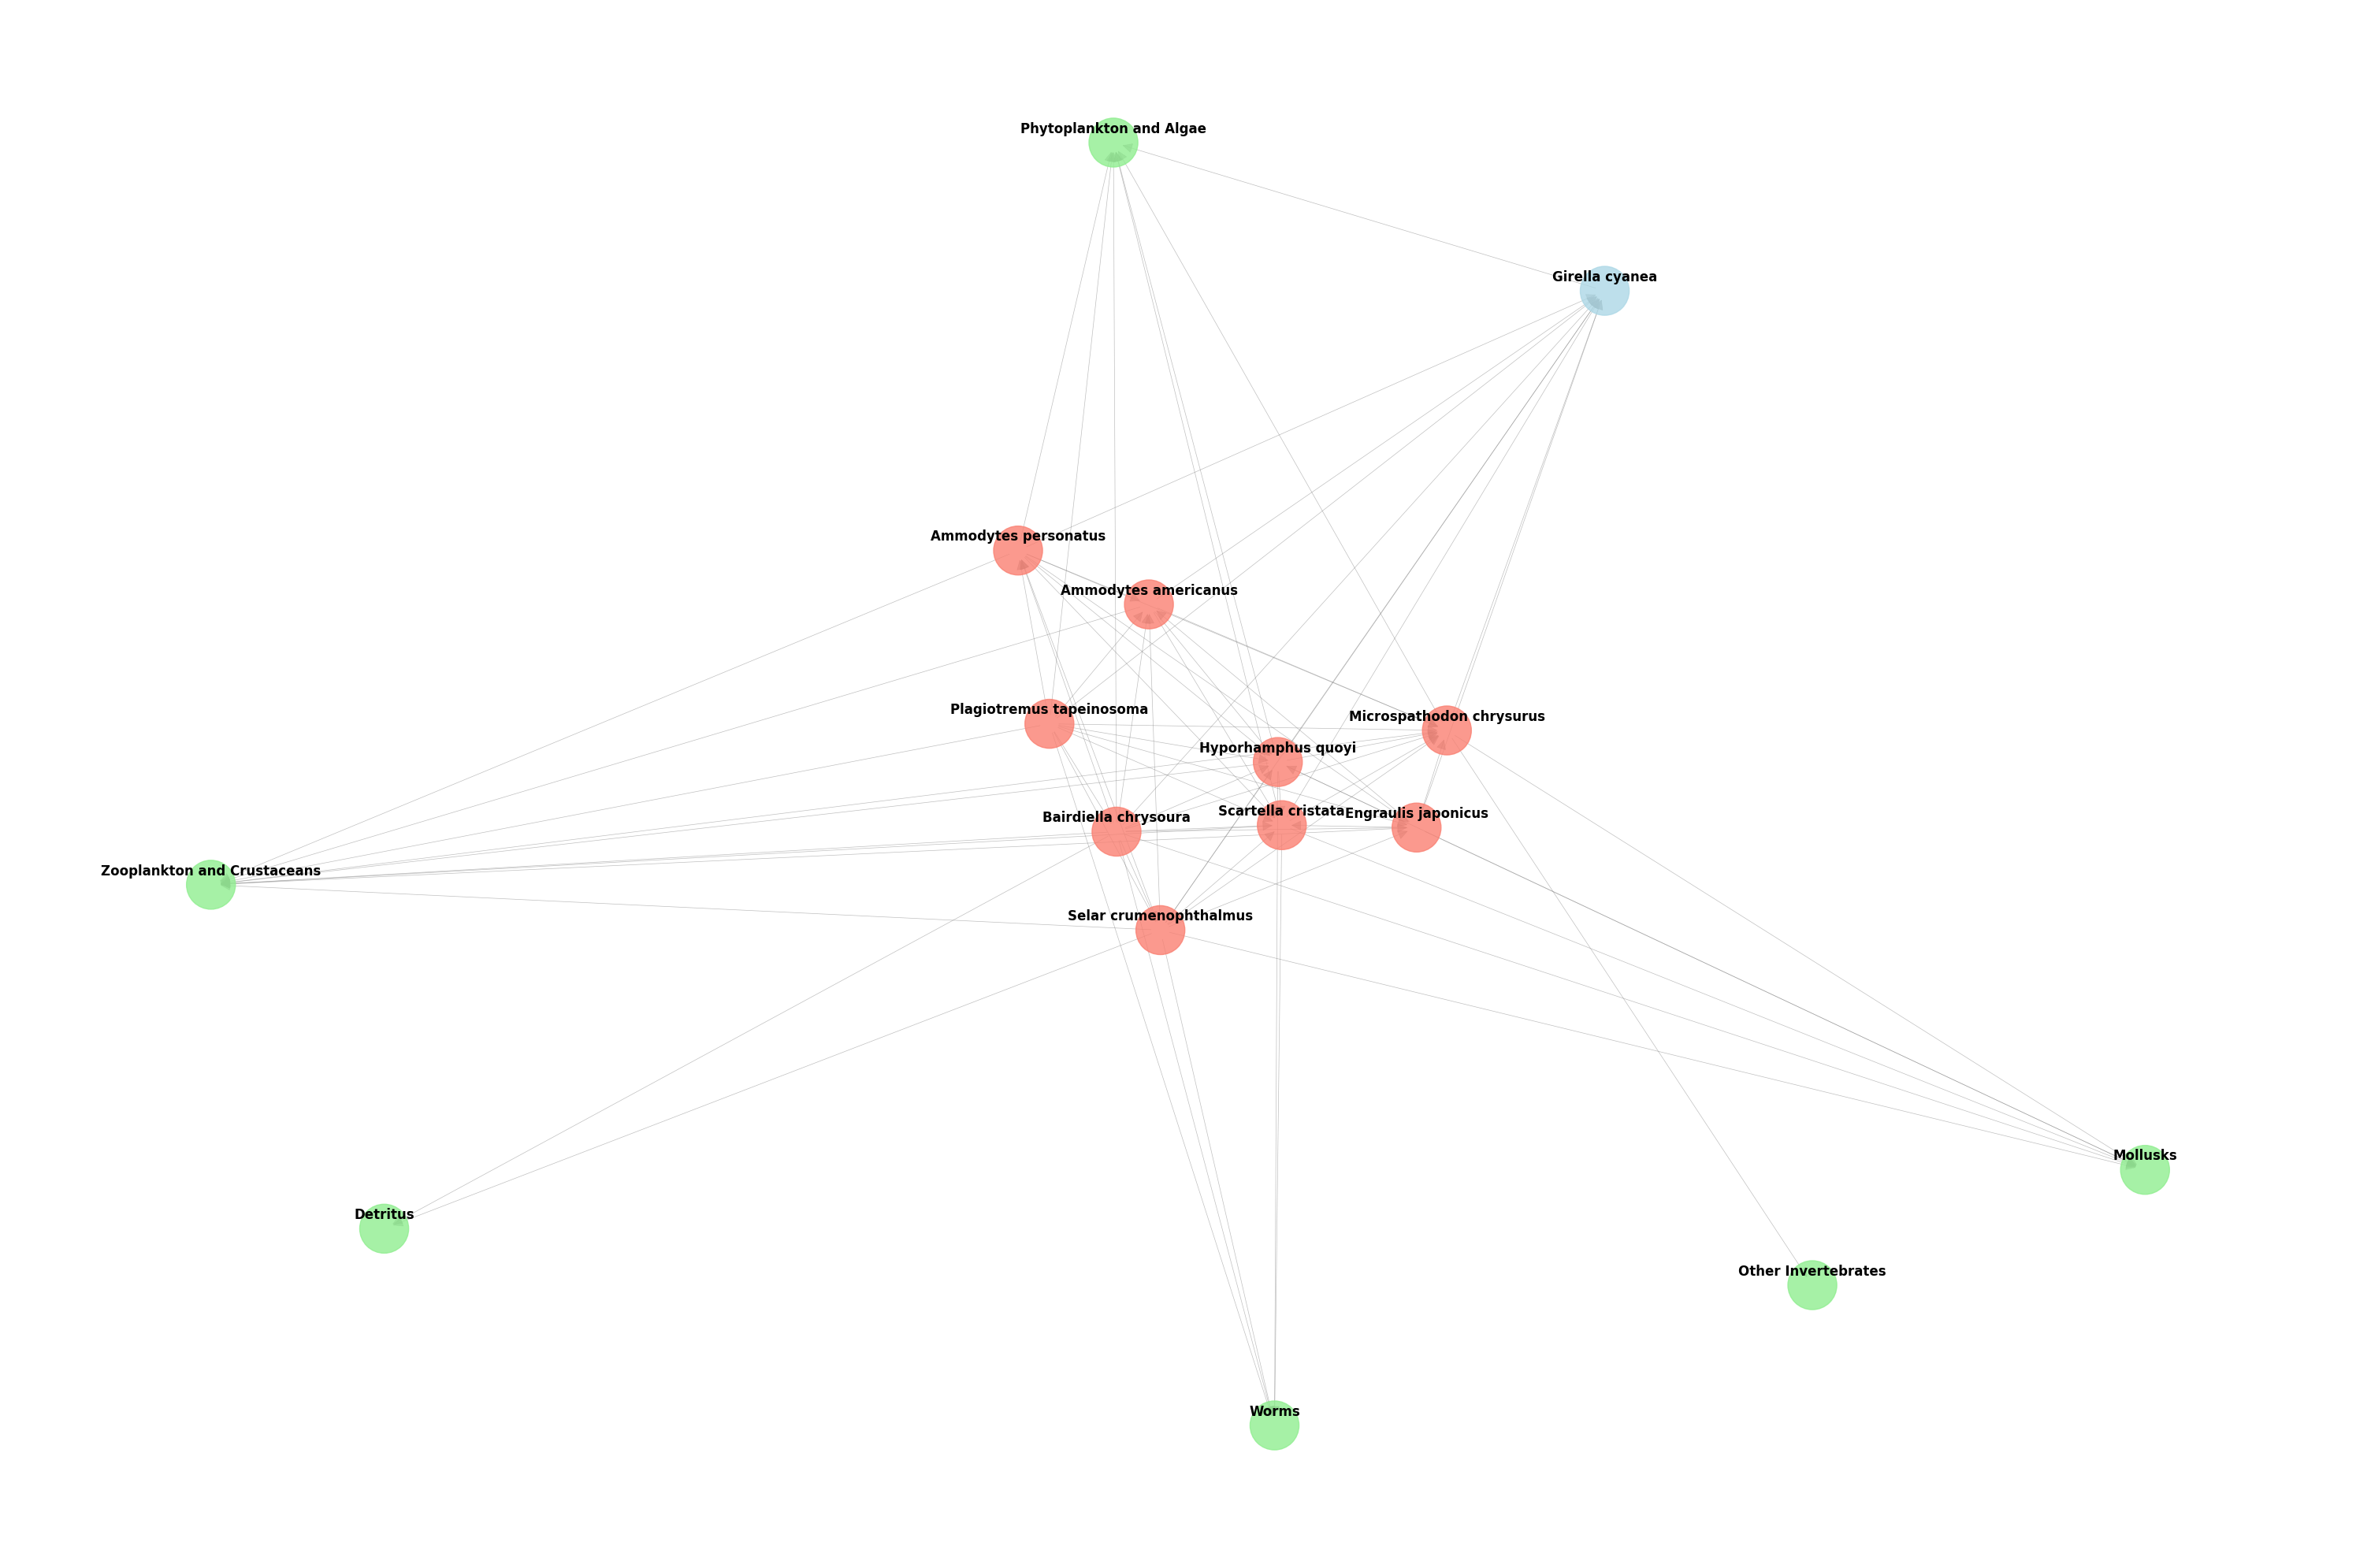

In [11]:
from src.helpers import visualize_trophic_web

visualize_trophic_web(G)

## Plot distribution of trophic levels

Let's next plot the distribution of trophic levels for the fish species in the food web for each sampling site in Galápagos.

Plot saved to trophic_distribution.png


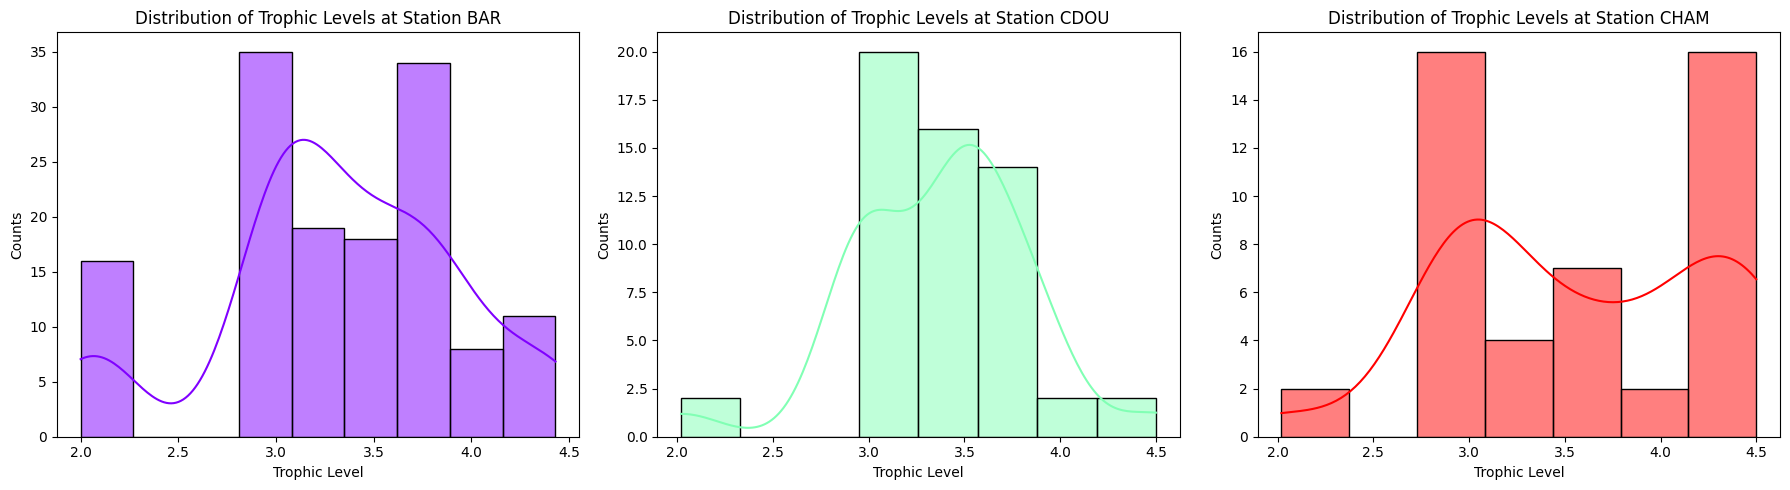

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Optional

def plot_trophic_level_distribution(df: pd.DataFrame, station_ids: Optional[List[str]] = None, output_file: Optional[str] = None):
    """
    Plot the distribution of trophic levels.

    Args:
        df (pd.DataFrame): Dataframe containing trophic information.
        station_ids (List[str], optional): List of station IDs to filter species by. Default is None.
        output_file (str, optional): Path to save the plot. If None, the plot will be displayed instead.

    Returns:
        None
    """
    # Remove rows with NaN trophic levels
    df = df.dropna(subset=['Troph'])

    if station_ids is None or len(station_ids) == 0:
        # Plot for all stations
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(data=df, x='Troph', kde=True, ax=ax)
        ax.set_xlabel('Trophic Level')
        ax.set_ylabel('Counts')
        ax.set_title('Distribution of Trophic Levels Across All Stations')
    else:
        # Determine the number of rows and columns for subplots
        n = len(station_ids)
        cols = min(3, n)
        rows = (n - 1) // cols + 1

        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows), squeeze=False)
        axes = axes.flatten()

        colors = plt.cm.rainbow(np.linspace(0, 1, n))

        for i, station_id in enumerate(station_ids):
            station_df = df[df['Stations'].str.contains(station_id, na=False)]
            
            sns.histplot(data=station_df, x='Troph', kde=True, ax=axes[i], color=colors[i])
            axes[i].set_xlabel('Trophic Level')
            axes[i].set_ylabel('Counts')
            axes[i].set_title(f'Distribution of Trophic Levels at Station {station_id}')

        # Remove any unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()

    # Save or display the plot
    if output_file:
        plt.savefig(output_file)
        print(f"Plot saved to {output_file}")
    plt.show()
    plt.close()



df = pd.read_csv('outputs/galapagos_trophic_info_with_station.csv')
df = df.dropna(subset=['Troph'])

# plot_trophic_level_distribution(df, station_id=None, output_file='trophic_distribution_BAR.png')
plot_trophic_level_distribution(df, station_ids=['BAR', 'CDOU', 'CHAM'], output_file='trophic_distribution.png')

## Investigating the correlation between trophic level and body size

The correlation between Trophic Level and Log(Body Length) is: 0.7064305833466327


/tmp/ipykernel_40959/4196690625.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Log_Length'] = np.log(data_cleaned['Length'])


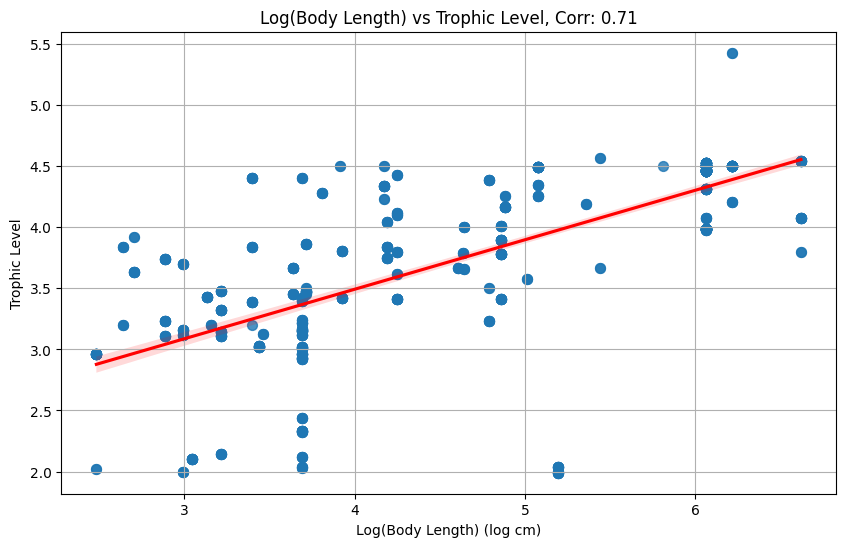

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('outputs/galapagos_trophic_info.csv')
data_cleaned = data.dropna(subset=['Troph', 'Length'])
data_cleaned['Log_Length'] = np.log(data_cleaned['Length'])

correlation = data_cleaned[['Troph', 'Log_Length']].corr().iloc[0, 1]
print(f"The correlation between Trophic Level and Log(Body Length) is: {correlation}")

plt.figure(figsize=(10, 6))
sns.regplot(data=data_cleaned, x='Log_Length', y='Troph', scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Log(Body Length) vs Trophic Level, Corr: {:.2f}'.format(correlation))
plt.xlabel('Log(Body Length) (log cm)')
plt.ylabel('Trophic Level')
plt.grid(True)
plt.show()

Fairly correlated, but not perfectly.